# Viz the database

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [2]:
driving_db = pd.read_csv('data/driving_log.csv', skipinitialspace=True)

driving_db.describe()

,steering,throttle,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


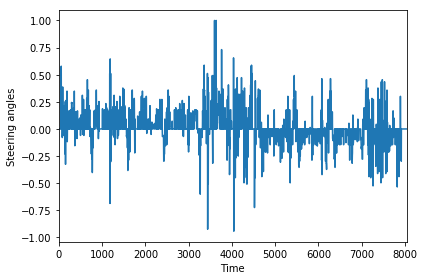

In [3]:
driving_db['steering'].plot()
plt.ylabel('Steering angles')
plt.xlabel('Time')
plt.tight_layout()

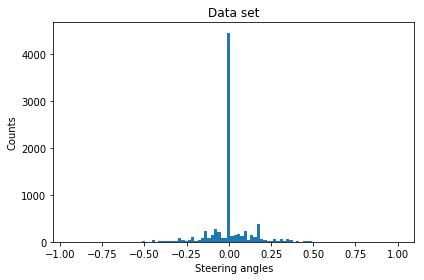

In [4]:
driving_db['steering'].plot('hist', bins=100)
plt.title('Data set')
plt.xlabel('Steering angles')
plt.ylabel('Counts')
plt.tight_layout()

# Process the image data

- Data balancing
- Including the left and right images
- Flip the left and right images
- PS: Flipping, Shifting, Brightness, Shadow
- Crop image
- Resizing

In [5]:
# Option to data/image process
BALANCE_DATA = True; undrop_rate = 0.1
ADD_LR_IMAGE = True; adjusted_angle = 0.4

PS_IMAGE = False
CROP_IMAGE = True; xpixel = 50
RESIZE_IMAGE = True; resize = (66, 200)
model_name = 'model.h5'

In [6]:
def balance_data(driving_db, undrop_rate):
    """Drop part of the data with zero steering angle."""
    driving_db_zeros = driving_db[driving_db['steering']==0]
    driving_db_nonzeros = driving_db[driving_db['steering']!=0]

    n_undrop = int(len(driving_db_zeros) * undrop_rate)
    indices = np.random.choice(range(len(driving_db_zeros)), n_undrop, replace=False)
    
    new_driving_db = pd.concat([driving_db_nonzeros, driving_db_zeros.iloc[indices]])
    
    return new_driving_db


def add_lr_image(driving_db, adjusted_angle):
    """Add left/right image to simulate the car recovery."""
    driving_db['left_steering'] = driving_db['steering'] - adjusted_angle
    driving_db['right_steering'] = driving_db['steering'] + adjusted_angle
    
    center_db = driving_db.loc[:, ['center', 'steering']]
    left_db = driving_db.loc[:, ['left', 'left_steering']]
    right_db = driving_db.loc[:, ['right', 'right_steering']]
    
    center_db.columns = ['center', 'steering']
    left_db.columns = ['center', 'steering']
    right_db.columns = ['center', 'steering']
    
    new_driving_db = pd.concat([center_db, left_db, right_db])
    
    return new_driving_db, center_db, left_db, right_db


def flip_image(img):
    """Balance the left and right turns."""
    pass

def ps_image(img):
    """Adjust brightness and shadow."""
    pass

def crop_image(image, xpixel):
    """Crop the less useful image."""
    img = image[xpixel:, :]
    return img


def resize_image(image, resize):
    """Resize the image"""
    img = cv2.resize(image, (resize[1], resize[0]))
    return img


def process_img(image):
    img = plt.imread('data/'+image)
    if PS_IMAGE:
        img = ps_image(img)
    if CROP_IMAGE:
        img = crop_image(img, xpixel)
    if RESIZE_IMAGE:
        img = resize_image(img, resize)
    return img

Data balanced!


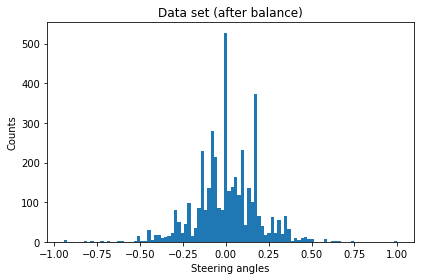

In [7]:
if BALANCE_DATA:
    driving_db = balance_data(driving_db, undrop_rate)
    print('Data balanced!')
    
driving_db['steering'].plot('hist', bins=100)
plt.title('Data set (after balance)')
plt.xlabel('Steering angles')
plt.ylabel('Counts')
plt.tight_layout()

In [8]:
images = os.listdir("data/IMG/")

if ADD_LR_IMAGE:
    driving_db, center_db, left_db, right_db = add_lr_image(driving_db, adjusted_angle)
    print('Left/right image added!')
else:
    driving_db = driving_db.loc[:, ['center', 'steering']]
    images = [i for i in images if i[:6] == 'center']

Left/right image added!


Image shape: (160, 320, 3)


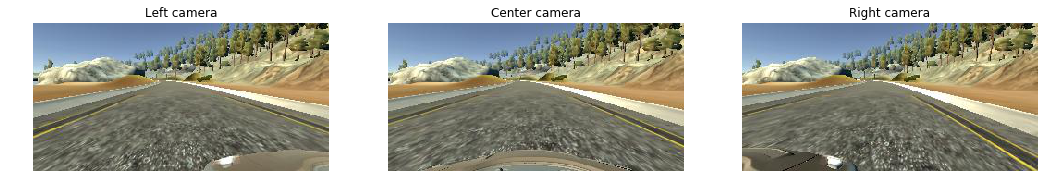

In [9]:
# Show a random left/center/right image
if ADD_LR_IMAGE:
    index = np.random.randint(len(left_db))
    figure = plt.figure(figsize=(18, 10))
    plt.subplot(1, 3, 1)
    img = plt.imread("data/"+left_db["center"].iloc[index])
    plt.imshow(img)
    plt.axis('off')
    plt.title('Left camera')
    
    plt.subplot(1, 3, 2)
    img = plt.imread("data/"+center_db["center"].iloc[index])
    plt.imshow(img)
    plt.axis('off')
    plt.title('Center camera')

    plt.subplot(1, 3, 3)
    img = plt.imread("data/"+right_db["center"].iloc[index])
    plt.imshow(img)
    plt.axis('off')
    plt.title('Right camera')
    
else:
    index = np.random.randint(len(driving_db))
    plt.imread("data/"+driving_db['center'][index])
    plt.imshow(img)
    plt.axis('off')
    plt.title('Center camera')
    
print('Image shape:', img.shape)
dsize = img.shape

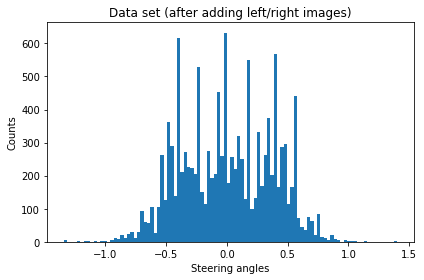

In [10]:
if ADD_LR_IMAGE:
    driving_db['steering'].plot('hist', bins=100)
    plt.title('Data set (after adding left/right images)')
    plt.xlabel('Steering angles')
    plt.ylabel('Counts')
    plt.tight_layout()

(110, 320, 3)


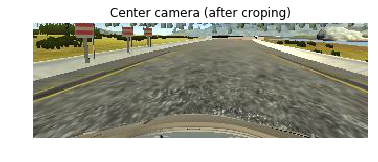

In [11]:
if CROP_IMAGE:
    index = np.random.randint(len(driving_db))
    img = plt.imread("data/"+driving_db['center'].iloc[index])
    img = crop_image(img, xpixel)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Center camera (after croping)')
    dsize = img.shape
    print(dsize)

(66, 200, 3)


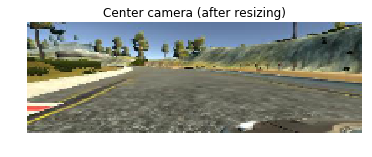

In [12]:
if RESIZE_IMAGE:
    index = np.random.randint(len(driving_db))
    img = plt.imread("data/"+driving_db['center'].iloc[index])
    img = resize_image(img, resize)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Center camera (after resizing)')
    dsize = img.shape
    print(dsize)

# Prepare training, validation data

In [13]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Shuffle
center, steering = shuffle(driving_db['center'], driving_db['steering']) 

# Split the data set into train and valid set
X_train, X_valid, y_train, y_valid = train_test_split(center, steering, test_size=0.2)

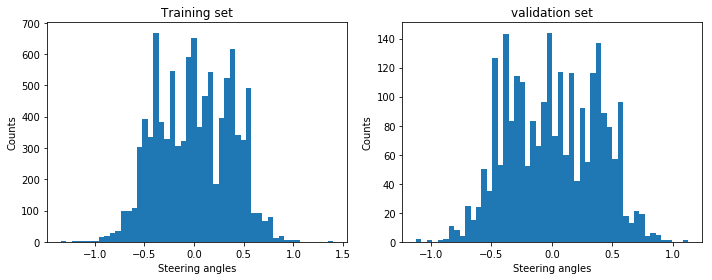

In [14]:
figure = plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.hist(y_train.values, bins=50)
plt.title('Training set')
plt.xlabel('Steering angles')
plt.ylabel('Counts')

plt.subplot(1, 2, 2)
plt.hist(y_valid.values, bins=50)
plt.title('validation set')
plt.xlabel('Steering angles')
plt.ylabel('Counts')

plt.tight_layout()

In [15]:
def batch_generator(X_data, y_data, batch_size):
    X_data_batch = np.zeros((batch_size, dsize[0], dsize[1], 3))
    n_examples = len(X_data)
    while 1:
        for offset in range(0, n_examples-batch_size, batch_size):
            end = offset + batch_size
            for i, img in enumerate(X_data[offset: end]):
                img = process_img(img)
                X_data_batch[i] = img
            y_data_batch = y_data[offset: end].values
            yield (X_data_batch, y_data_batch)          

# Build the model

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Lambda, MaxPooling2D, Convolution2D, BatchNormalization

Using TensorFlow backend.


In [17]:
def nn_model():
    model = Sequential()
    model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(dsize[0], dsize[1], 3)))
    model.add(Convolution2D(24, 5, 5, border_mode='valid', subsample=(2, 2), activation='relu', name='Conv1'))
    #model.add(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='same'))
    
    model.add(Convolution2D(36, 5, 5, border_mode='valid', subsample=(2, 2), activation='relu', name='Conv2'))
    #model.add(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='same'))
    
    model.add(Convolution2D(48, 5, 5, border_mode='valid', subsample=(2, 2), activation='relu', name='Conv3'))
    #model.add(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='same'))

    model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(1, 1), activation='relu', name='Conv4'))
    
    model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(1, 1), activation='relu', name='Conv5'))

    model.add(Flatten())
    #model.add(Dropout(0.2))
    
    model.add(Dense(1164, activation='relu', name='FC0'))
    
    model.add(Dense(100, activation='relu', name='FC1'))

    model.add(Dense(50, activation='relu', name='FC2'))
    
    model.add(Dense(10, activation='relu', name='FC3'))
    
    model.add(Dense(1))
        
    return model

In [18]:
from keras.optimizers import Adam

model = nn_model()

adam = Adam(lr=0.0001)
model.compile(optimizer=adam, 
              loss='mse')

In [19]:
# model.summary()

# Train the model

In [ ]:
batch_size = 64
nb_epoch = 20

train_batch_generator = batch_generator(X_train, y_train, batch_size)
valid_batch_generator = batch_generator(X_valid, y_valid, batch_size)

In [ ]:
samples_per_epoch = (len(X_train) // batch_size) * batch_size
nb_val_samples = (len(X_valid) // batch_size) * batch_size

model.fit_generator(train_batch_generator, 
                    samples_per_epoch=samples_per_epoch, 
                    nb_epoch=nb_epoch,
                    validation_data=valid_batch_generator, 
                    nb_val_samples=nb_val_samples)

model.save(model_name)
print('Finish training!')
#del model

Epoch 1/20
9856/9856 [==============================] - 21s - loss: 0.1083 - val_loss: 0.0750

# Viz the model layer by layer

In [ ]:
# from keras.models import load_model
# model = load_model(model_name)

# # Only the architecture
# # json_string = model.to_json()

# # Only the weights
# # model.save_weights('my_model_weights.h5')

In [ ]:
# # Viz the model arch.
# from keras.utils.visualize_util import plot
# plot(model, to_file='model.png')

In [ ]:
# from keras.models import Model


# img = process_img(X_train[0])
# print(img.shape)
# img = np.expand_dims(img, axis=0)

# Layer1 = Model(input=model.input, output=model.get_layer('Conv1').output)
# Layer2 = Model(input=model.input, output=model.get_layer('Conv2').output)

# # remember to preprocess it!
# steering = model.predict(img)
# features_layer1 = Layer1.predict(img)
# features_layer2 = Layer2.predict(img)

In [ ]:
# fig = plt.figure(figsize=(10, 8))
# for i in range(32):
#     plt.subplot(8, 4, i+1)
#     img = features_layer1[0, :, :, i]
#     plt.imshow(img)
#     plt.axis('off')

In [ ]:
# fig = plt.figure(figsize=(10, 8))
# for i in range(64):
#     plt.subplot(8, 8, i+1)
#     img = features_layer2[0, :, :, i]
#     plt.imshow(img)
#     plt.axis('off')